In [1]:
import sys
sys.path.insert(0, '../src')
import harmoutil

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input, Dense, GRU, concatenate

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

import matplotlib.pyplot as plt

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
print("---Raw data---")
print("Number of sections: {}".format(len(raw_data)))
print("Sample section: {}\n".format(raw_data[0]))
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
print("---Transpose and augment data---")
print("Number of sections after data augmentation: {}".format(len(augmented_data)))
print("Sample section: {}\n".format(augmented_data[0]))
data = [harmoutil.to_sevenths(section) for section in augmented_data]
print("---Truncate chords to sevenths---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))
data = [harmoutil.melody_to_octave_range(section) for section in data]
print("---Convert melody to integers---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))

---Raw data---
Number of sections: 2408
Sample section: [('Bb6', [[58.0], [58.0]]), ('G7', [[-1.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]]), ('Bb', [[-1.0], [-1.0]]), ('G-7', [[50.0], [57.0, 60.0]]), ('C-7', [[58.0, 55.0], [58.0]]), ('F7', [[61.0], [60.0, 58.0]]), ('F-7', [[60.0], [58.0]]), ('Bb7', [[56.0, 60.0], [59.0, 57.0]]), ('Eb7', [[58.0, 54.0], [55.0, 58.0]]), ('Ab7', [[61.0, 56.0], [61.0, 62.0]]), ('D-7', [[58.0, 60.0], [55.0, 58.0]]), ('G7', [[58.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]])]

---Transpose and augment data---
Number of sections after data augmentation: 28884
Sample section: [('E6', [[52.0], [52.0]]), ('Db7', [[-1.0], [-1.0]]), ('Gb-7', [[-1.0], [-1.0]]), ('B7', [[-1.0], [-1.0]]), ('E', [[-1.0], [-1.0]]), ('Db-7', [[44.0], [51.0, 54.0]]), ('Gb-7', [[52.0, 49.0], [52.0]]), ('B7', [[55.0], [54.0, 52.0]]), ('B-7', [[54.0], [52.0]]), ('E7', [[50.0, 54.0], [53.0, 51.0]]), ('A7', [[52.0, 48.0], [49.0, 52.0]]), ('D7', [[55.0, 

In [3]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

---Remove sections with augmented major chord---
Number of sections: 28836

Number of sections: 28836 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 333480 | Sample chord: E6
Number of melodies 333480 | Sample melody: [4, 4]
Number of melody notes in the data: 2195328 | Sample melody note: 4


In [4]:
# Create categorical data mappings

# Note to integer index
note_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)
print("Melody note to integer mapping:\n {}\n".format(note_to_int))

# Integer to note
int_to_note = dict([(k, v) for v, k in note_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_note))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))


# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Bb-': 42, 'Eb-6': 118, 'Ebm7b5': 124, 'Ab-j7': 15, 'Bb6': 46, 'Asus': 28, 'Fj7': 144, 'G': 150, 'Eo': 131, 'Aj7': 24, 'Dbsus': 97, 'Db+7': 86, 'A': 0, 'G+': 151, 'E-7': 110, 'Bm7b5': 55, 'Ebo': 125, 'Bo': 56, 'Gb6': 166, 'C-7': 65, 'Bbo': 50, 'D6': 82, 'Bb7': 47, 'B+': 31, 'D': 75, 'Bb-j7': 45, 'Gb7': 167, 'G7': 158, 'Gsus': 178, 'Bb-7': 44, 'Db-7': 89, 'Ao7': 27, 'Ao': 26, 'Gb-6': 163, 'G-6': 154, 'Dsus7': 104, 'F+7': 137, 'F-7': 140, 'D-6': 79, 'Cm7b5': 70, 'Gbm7b5': 169, 'Bsus7': 59, 'E-6': 109, 'Esus7': 134, 'B-7': 35, 'Eb+': 115, 'Gbo7': 171, 'Dbj7': 93, 'Bb+': 40, 'Bj7': 54, 'Am7b5': 25, 'Gj7': 174, 'Ebsus7': 128, 'Abo7': 21, 'Ab-6': 13, 'Abo': 20, 'B': 30, 'Bb-6': 43, 'Absus7': 23, 'C+

In [5]:
# Define numerical variables

n_samples = len(chords)
n_notes = len(note_to_int)
n_chords = len(chord_to_int)
max_melody_len = max([len(mel_seq) for mel_seq in notes_by_chords])
chord_context_len = 7

print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum melody sequence length: {}".format(max_melody_len))
print("Fixed context chord sequence length: {}".format(7))

Total number of samples: 333480
Number of distinct melody notes: 14
Number of distinct chord labels: 182
Maximum melody sequence length: 135
Fixed context chord sequence length: 7


In [6]:
# Prepare tensor data

def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_melody_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))


# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [7]:
# Build tensors

X_melody = np.zeros((n_samples, max_melody_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
Y = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
        X_chords[i, j, chord_to_int[chord]] = 1
        
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1


In [8]:
# Test melody tensor

def test_samples_axis(melody_tensor):
    count = 0
    sample_axis_sums = melody_tensor.sum(axis=2)
    for entry in sample_axis_sums.ravel():
        count += 1
        if not (entry == 1):
            return (False, count)
    return (True, count, np.sum(sample_axis_sums), np.sum(melody_tensor), np.sum(melody_tensor, dtype=np.int32))

# Test n_samples axis i.e. axis 1. If there are any "holes" (non-1) entry, it's a problem
print("{} = (n_samples, max_melody_len, n_notes)".format(X_melody.shape))
print(test_samples_axis(X_melody))

(333480, 135, 14) = (n_samples, max_melody_len, n_notes)
(True, 45019800, 45019800.0, 44982130.0, 45019800)


In [9]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_train, Y_aux = Y[train_index], Y[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_valid, Y_test = Y[valid_index], Y[test_index]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 182)        0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           54912       input_1[0][0]                    
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 128)  

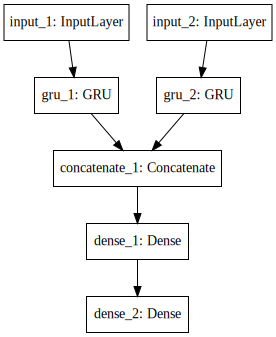

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_melody_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

chords_input = Input(shape=(chord_context_len, n_chords))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru, chords_gru])

chord_hidden1 = Dense(n_chords, activation='relu')(concat)
chord_dense = Dense(n_chords, activation='softmax')(chord_hidden1)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [11]:
# Introduce Early-Stopping and Save-Best-Performance callbacks
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "../models/label-Mel1-Cho1-FC2_150ep.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[bp])

Train on 266784 samples, validate on 33348 samples
Epoch 1/150
266784/266784 [==============================] - 433s - loss: 2.9452 - acc: 0.3420 - val_loss: 2.5170 - val_acc: 0.4230
Epoch 2/150
266784/266784 [==============================] - 436s - loss: 2.3936 - acc: 0.4358 - val_loss: 2.2925 - val_acc: 0.4668
Epoch 3/150
266784/266784 [==============================] - 436s - loss: 2.1886 - acc: 0.4738 - val_loss: 2.1576 - val_acc: 0.4984
Epoch 4/150
266784/266784 [==============================] - 436s - loss: 2.0387 - acc: 0.5082 - val_loss: 2.0627 - val_acc: 0.5163
Epoch 5/150
266784/266784 [==============================] - 436s - loss: 1.9129 - acc: 0.5380 - val_loss: 1.9857 - val_acc: 0.5408
Epoch 6/150
266784/266784 [==============================] - 434s - loss: 1.8075 - acc: 0.5617 - val_loss: 1.9025 - val_acc: 0.5602
Epoch 7/150
266784/266784 [==============================] - 433s - loss: 1.7126 - acc: 0.5833 - val_loss: 1.8627 - val_acc: 0.5684
Epoch 8/150
266784/266784

266784/266784 [==============================] - 434s - loss: 1.0707 - acc: 0.7264 - val_loss: 1.5061 - val_acc: 0.6675
Epoch 27/150
266784/266784 [==============================] - 434s - loss: 1.0599 - acc: 0.7278 - val_loss: 1.4992 - val_acc: 0.6681
Epoch 28/150
266784/266784 [==============================] - 434s - loss: 1.0494 - acc: 0.7299 - val_loss: 1.4881 - val_acc: 0.6723
Epoch 29/150
266784/266784 [==============================] - 434s - loss: 1.0411 - acc: 0.7313 - val_loss: 1.4896 - val_acc: 0.6754
Epoch 30/150
266784/266784 [==============================] - 433s - loss: 1.0317 - acc: 0.7334 - val_loss: 1.4885 - val_acc: 0.6775
Epoch 31/150
266784/266784 [==============================] - 436s - loss: 1.0239 - acc: 0.7348 - val_loss: 1.4807 - val_acc: 0.6770
Epoch 32/150
266784/266784 [==============================] - 436s - loss: 1.0166 - acc: 0.7369 - val_loss: 1.4793 - val_acc: 0.6786
Epoch 33/150
266784/266784 [==============================] - 436s - loss: 1.0097 

266784/266784 [==============================] - 433s - loss: 0.9320 - acc: 0.7530 - val_loss: 1.4636 - val_acc: 0.6914
Epoch 55/150
266784/266784 [==============================] - 433s - loss: 0.9311 - acc: 0.7533 - val_loss: 1.4548 - val_acc: 0.6938
Epoch 56/150
266784/266784 [==============================] - 433s - loss: 0.9276 - acc: 0.7531 - val_loss: 1.4457 - val_acc: 0.6982
Epoch 57/150
266784/266784 [==============================] - 434s - loss: 0.9242 - acc: 0.7542 - val_loss: 1.4583 - val_acc: 0.6952
Epoch 58/150
266784/266784 [==============================] - 434s - loss: 0.9222 - acc: 0.7543 - val_loss: 1.4575 - val_acc: 0.6944
Epoch 59/150
266784/266784 [==============================] - 433s - loss: 0.9204 - acc: 0.7546 - val_loss: 1.4641 - val_acc: 0.6949
Epoch 60/150
266784/266784 [==============================] - 434s - loss: 0.9186 - acc: 0.7559 - val_loss: 1.4558 - val_acc: 0.6960
Epoch 61/150
266784/266784 [==============================] - 435s - loss: 0.9169 

266784/266784 [==============================] - 433s - loss: 0.8988 - acc: 0.7586 - val_loss: 1.4474 - val_acc: 0.7058
Epoch 85/150
266784/266784 [==============================] - 433s - loss: 0.8986 - acc: 0.7593 - val_loss: 1.4527 - val_acc: 0.6995
Epoch 86/150
266784/266784 [==============================] - 435s - loss: 0.8973 - acc: 0.7590 - val_loss: 1.4578 - val_acc: 0.6970
Epoch 87/150
266784/266784 [==============================] - 435s - loss: 0.8973 - acc: 0.7592 - val_loss: 1.4508 - val_acc: 0.7035
Epoch 88/150
266784/266784 [==============================] - 434s - loss: 0.8953 - acc: 0.7597 - val_loss: 1.4586 - val_acc: 0.7006
Epoch 89/150
266784/266784 [==============================] - 433s - loss: 0.8964 - acc: 0.7594 - val_loss: 1.4599 - val_acc: 0.6960
Epoch 90/150
266784/266784 [==============================] - 434s - loss: 0.8946 - acc: 0.7598 - val_loss: 1.4571 - val_acc: 0.6983
Epoch 91/150
266784/266784 [==============================] - 434s - loss: 0.8949 

266784/266784 [==============================] - 440s - loss: 0.8844 - acc: 0.7613 - val_loss: 1.4548 - val_acc: 0.7033
Epoch 117/150
266784/266784 [==============================] - 441s - loss: 0.8837 - acc: 0.7617 - val_loss: 1.4555 - val_acc: 0.7041
Epoch 118/150
266784/266784 [==============================] - 440s - loss: 0.8859 - acc: 0.7608 - val_loss: 1.4599 - val_acc: 0.7015
Epoch 119/150
266784/266784 [==============================] - 440s - loss: 0.8830 - acc: 0.7620 - val_loss: 1.4533 - val_acc: 0.7027
Epoch 120/150
266784/266784 [==============================] - 440s - loss: 0.8831 - acc: 0.7616 - val_loss: 1.4649 - val_acc: 0.7020
Epoch 121/150
266784/266784 [==============================] - 440s - loss: 0.8825 - acc: 0.7614 - val_loss: 1.4644 - val_acc: 0.7016
Epoch 122/150
266784/266784 [==============================] - 439s - loss: 0.8816 - acc: 0.7614 - val_loss: 1.4574 - val_acc: 0.7016
Epoch 123/150
266784/266784 [==============================] - 436s - loss: 

266784/266784 [==============================] - 441s - loss: 0.8744 - acc: 0.7637 - val_loss: 1.4565 - val_acc: 0.7036
Epoch 148/150
266784/266784 [==============================] - 440s - loss: 0.8709 - acc: 0.7642 - val_loss: 1.4576 - val_acc: 0.7018
Epoch 149/150
266784/266784 [==============================] - 442s - loss: 0.8678 - acc: 0.7652 - val_loss: 1.4543 - val_acc: 0.7032
Epoch 150/150
266784/266784 [==============================] - 441s - loss: 0.8661 - acc: 0.7654 - val_loss: 1.4682 - val_acc: 0.7027


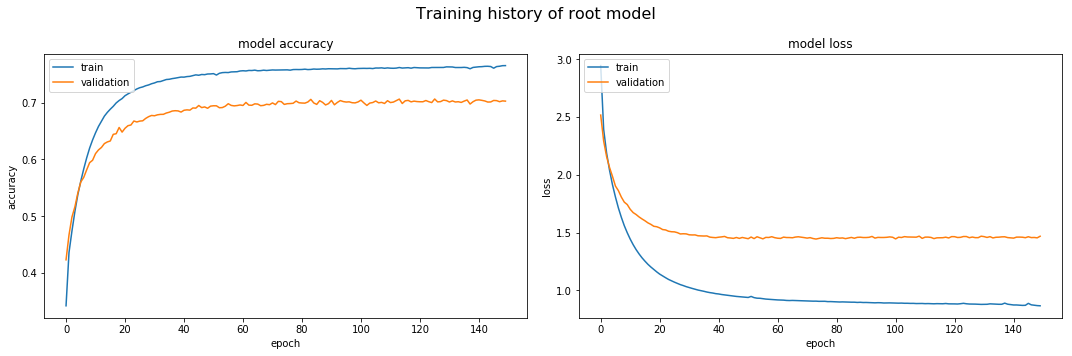

In [13]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
# Load best performance model
model = load_model("../models/label-Mel1-Cho1-FC2_150ep.h5")

In [15]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_pred = model.predict([X_melody_test, X_chords_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_test, Y_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_test, Y_pred)))

Categorical accuracy of combined chord label prediction: 0.6990
Kappa score of combined chord label prediction: 0.6911


In [16]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_pred_pitch = label_to_pitch_tensors(Y_pred)
Y_test_pitch = label_to_pitch_tensors(Y_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_test_pitch, Y_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_test_pitch, Y_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.8728
TP: 105082 TN: 244191 FP: 25859 FN: 25044
Kappa score of combined chord pitch prediction: 0.7106


In [61]:
# print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(Y_test_pitch, Y_pred_pitch)))